In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("ggplot")

In [19]:


#############################################################################
# Prepare data and import into a dataframe
#############################################################################
# 1) Export Data from healthkit using [qs-access](https://itunes.apple.com/us/app/qs-access/id920297614?mt=8) app 
# 2) Update the script to point to your file name.

exported_and_trandformed_csv_file = "data/weight.csv"
df = pd.read_csv(exported_and_trandformed_csv_file)

#############################################################################
# Clean up the data.
#############################################################################

# make dataColumn a datetime.
date_column_name="Start"
df[date_column_name] = pd.to_datetime(df[date_column_name])

# and then apply stats to reasonable time period.
date_group_column_name = "month_year" 
df[date_group_column_name]=df[date_column_name].apply(lambda t:f"{t.month}-{t.year-2000}")

# Normalize weight into lbs.
weight_lbs_column_name = "Weight (lb)"

Text(0,0.5,'lbs')

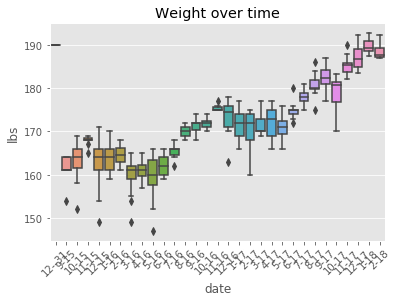

In [20]:

#############################################################################
# Make pretty pictures.
#############################################################################
ax = sns.boxplot(x=date_group_column_name, y=weight_lbs_column_name, data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("Weight over time")
ax.set_xlabel("date")
ax.set_ylabel("lbs")
